In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_full = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')
df_full.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [3]:
cols = ['engine_displacement','horsepower','vehicle_weight','model_year','fuel_efficiency_mpg']
cols

['engine_displacement',
 'horsepower',
 'vehicle_weight',
 'model_year',
 'fuel_efficiency_mpg']

In [4]:
df = df_full[cols].copy()
df.head(2)

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217


## EDA

In [5]:
#no of rows
len(df)

9704

### Question 1. Missing values

In [6]:
#missing values
df.isna().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [7]:
df['fuel_efficiency_mpg'].describe()

count    9704.000000
mean       14.985243
std         2.556468
min         6.200971
25%        13.267459
50%        15.006037
75%        16.707965
max        25.967222
Name: fuel_efficiency_mpg, dtype: float64

### Fuel Efficiency

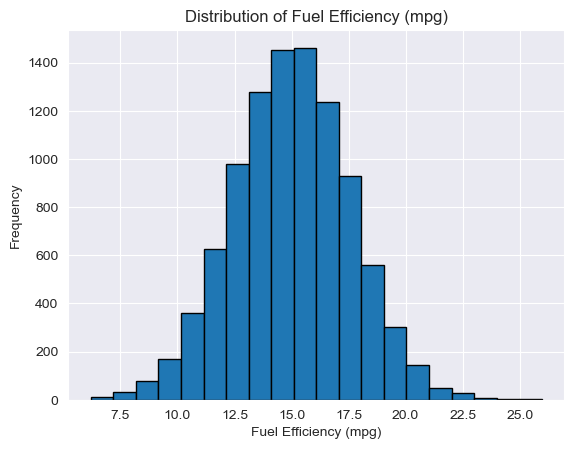

In [8]:
# histogram
plt.hist(df['fuel_efficiency_mpg'], bins=20, edgecolor='black')
plt.xlabel("Fuel Efficiency (mpg)")
plt.ylabel("Frequency")
plt.title("Distribution of Fuel Efficiency (mpg)")
plt.show()

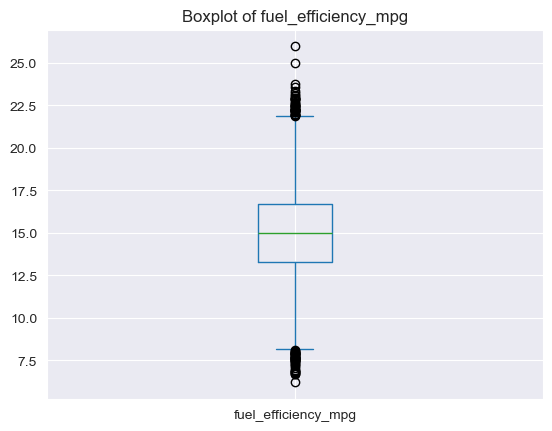

In [9]:
# boxplot
df['fuel_efficiency_mpg'].plot(kind='box', title="Boxplot of fuel_efficiency_mpg")
plt.show()

### Question 2. Median for horse power

In [10]:
 df['horsepower'].median()

149.0

In [11]:
df['horsepower'].mode()[0]

np.float64(152.0)

## Prepare and split the dataset

In [12]:
def train_val_test_split(data, seed=42):
    n = len(data)
    idx = np.arange(n)
    rng = np.random.RandomState(seed)
    rng.shuffle(idx)

    n_train = int(0.6*n)
    n_val   = int(0.2*n)
    n_test  = n - n_train - n_val

    df_train = data.iloc[idx[:n_train]].reset_index(drop=True)
    df_val   = data.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
    df_test  = data.iloc[idx[n_train+n_val:]].reset_index(drop=True)
    return df_train, df_val, df_test

In [13]:
#def prepare_X(df):
   # X = df[['engine_displacement','horsepower','vehicle_weight',#'model_year']].values
    # add bias
    #ones = np.ones((X.shape[0], 1))
    #return np.hstack([ones, X])


def prepare_X(df):
    X = df[['engine_displacement','horsepower','vehicle_weight','model_year']].values
    # add bias
    ones = np.ones((X.shape[0]))
    return np.column_stack([ones, X])

def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred)**2))

def train_linear_regression(X, y, r=0.0):
    # ridge closed form: w = (X^T X + r*I)^-1 X^T y
    XTX = X.T @ X
    if r > 0:
        XTX = XTX + r * np.eye(XTX.shape[0])
    w = np.linalg.inv(XTX) @ X.T @ y
    return w


In [14]:
df_train, df_val, df_test = train_val_test_split(df, seed=42)

y_train = df_train['fuel_efficiency_mpg'].values
y_val   = df_val['fuel_efficiency_mpg'].values
y_test  = df_test['fuel_efficiency_mpg'].values
feature_cols = ['engine_displacement','horsepower','vehicle_weight','model_year']

### Q3: handle missing values two ways and compare on validation

In [15]:
# fill missing with 0

Xtr0 = prepare_X(df_train.fillna(0))
Xva0 = prepare_X(df_val.fillna(0))

w0 = train_linear_regression(Xtr0, y_train, r=0.0)
rmse0 = rmse(y_val, Xva0 @ w0)
print("RMSE (fill 0):", round(rmse0, 2))

RMSE (fill 0): 0.52


In [16]:
# fill missing with the train mean

train_means = df_train[feature_cols].mean()

df_train_mean = df_train.fillna(train_means)
df_val_mean   = df_val.fillna(train_means)

Xtrm = prepare_X(df_train_mean)
Xvam = prepare_X(df_val_mean)

wm = train_linear_regression(Xtrm, y_train, r=0.0)
rmsem = rmse(y_val, Xvam @ wm)
print("RMSE (fill train mean):", round(rmsem, 2))


RMSE (fill train mean): 0.46


In [17]:
r0, rm = round(rmse0, 2), round(rmsem, 2)
if r0 < rm:
    print("Answer: With 0")
elif rm < r0:
    print("Answer: With mean")
else:
    print("Answer: Both are equally good")


Answer: With mean


### Question 4. Best regularization

In [18]:
# Prepare train/val data with missing values filled as 0

Xtr0 = prepare_X(df_train.fillna(0))
Xva0 = prepare_X(df_val.fillna(0))

y_train = df_train['fuel_efficiency_mpg'].values
y_val   = df_val['fuel_efficiency_mpg'].values

In [19]:
# Train with different r values

r_list = [0, 0.01, 0.1, 1, 5, 10, 100]
results = []

for r in r_list:
    w = train_linear_regression(Xtr0, y_train, r=r)
    y_pred = Xva0 @ w
    score = rmse(y_val, y_pred)
    results.append((r, round(score, 2)))

print("Validation RMSE by r:", results)

Validation RMSE by r: [(0, np.float64(0.52)), (0.01, np.float64(0.52)), (0.1, np.float64(0.52)), (1, np.float64(0.52)), (5, np.float64(0.52)), (10, np.float64(0.52)), (100, np.float64(0.52))]


In [20]:
# Pick the best

best_r = min(results, key=lambda x: (x[1], x[0]))[0]
print("Best r:", best_r)

Best r: 0


### Question 5. RMSE Standard Deviation

In [21]:
# Loop over seeds 0–9

rmses = []

for seed in range(10):
    df_train, df_val, df_test = train_val_test_split(df, seed=seed)

    Xtr = prepare_X(df_train.fillna(0))
    Xva = prepare_X(df_val.fillna(0))

    ytr = df_train['fuel_efficiency_mpg'].values
    yva = df_val['fuel_efficiency_mpg'].values

    w = train_linear_regression(Xtr, ytr, r=0.0)
    y_pred = Xva @ w
    score = rmse(yva, y_pred)
    rmses.append(score)

print("Validation RMSE for seeds 0–9:", [round(s, 3) for s in rmses])

Validation RMSE for seeds 0–9: [np.float64(0.521), np.float64(0.522), np.float64(0.523), np.float64(0.516), np.float64(0.511), np.float64(0.529), np.float64(0.532), np.float64(0.51), np.float64(0.515), np.float64(0.513)]


In [22]:
# Compute standard deviation

std_val = round(np.std(rmses), 3)
print("Standard deviation:", std_val)

Standard deviation: 0.007


### Question 6. Evaluation on test

In [23]:
# Question 6. Evaluation on test

df_train, df_val, df_test = train_val_test_split(df, seed=9)

In [24]:
# Combine train + validation

df_trainval = pd.concat([df_train, df_val], ignore_index=True)

y_trainval = df_trainval['fuel_efficiency_mpg'].values
y_test     = df_test['fuel_efficiency_mpg'].values

In [25]:
# fill NA with 0

X_trainval = prepare_X(df_trainval.fillna(0))
X_test     = prepare_X(df_test.fillna(0))

In [26]:
# Train linear regression with r = 0.001

w = train_linear_regression(X_trainval, y_trainval, r=0.001)

In [27]:
# Evaluate RMSE on the test set

y_pred = X_test @ w
rmse_test = rmse(y_test, y_pred)
print("Test RMSE:", round(rmse_test, 3))

Test RMSE: 0.516
